In [594]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 1. Análisis inicial y limpieza de datos

In [595]:
os.chdir('C:\\Users\\carmi\\OneDrive\\Documentos\\Máster en Business Analytics y Big Data\\10. TFM')
df = pd.read_csv('bank.csv', sep=',')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [596]:
df.shape

(11162, 17)

In [597]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [598]:
df['day'] = df['day'].astype(object)

In [599]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  object
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [600]:
for col in df.select_dtypes(include='object').columns:
    print(col,'-->',df[col].unique())

job --> ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital --> ['married' 'single' 'divorced']
education --> ['secondary' 'tertiary' 'primary' 'unknown']
default --> ['no' 'yes']
housing --> ['yes' 'no']
loan --> ['no' 'yes']
contact --> ['unknown' 'cellular' 'telephone']
day --> [5 6 7 8 9 12 13 14 15 16 19 20 21 23 26 27 28 29 30 2 3 4 11 17 18 24 1
 10 22 25 31]
month --> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome --> ['unknown' 'other' 'failure' 'success']
deposit --> ['yes' 'no']


In [601]:
print(df['job'].value_counts())
print(df['education'].value_counts())
print(df['contact'].value_counts())
print(df['poutcome'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64
unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64


In [602]:
df['contact'] = df['contact'].map({'unknown': 'cellular','cellular':'cellular','telephone':'telephone'})
df['poutcome'] = df['poutcome'].map({'unknown': 'new','other':'other','failure':'failure','success':'success'})

In [603]:
print(df['contact'].value_counts())
print(df['poutcome'].value_counts())

cellular     10388
telephone      774
Name: contact, dtype: int64
new        8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64


In [604]:
df.describe()

,age,balance,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,3881.000000,63.000000,854.000000,58.000000


In [605]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [606]:
df.shape

(11162, 17)

In [607]:
df_num = df.select_dtypes(include='number')

vt = VarianceThreshold(threshold=1)
_ = vt.fit(df_num)
mask = vt.get_support()
df_reducido = df_num.loc[:, mask]
df_reducido.shape

(11162, 6)

The correlation DataFrame is:
               age   balance  duration  campaign     pdays  previous
age       1.000000  0.112300  0.000189 -0.005278  0.002774  0.020169
balance   0.112300  1.000000  0.022436 -0.013894  0.017411  0.030805
duration  0.000189  0.022436  1.000000 -0.041557 -0.027392 -0.026716
campaign -0.005278 -0.013894 -0.041557  1.000000 -0.102726 -0.049699
pdays     0.002774  0.017411 -0.027392 -0.102726  1.000000  0.507272
previous  0.020169  0.030805 -0.026716 -0.049699  0.507272  1.000000 



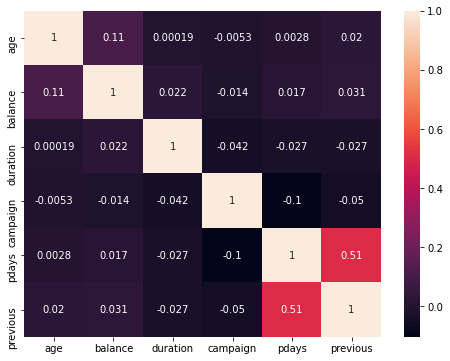

In [608]:
corr_df = df.corr(method='pearson')
print("The correlation DataFrame is:")
print(corr_df, "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

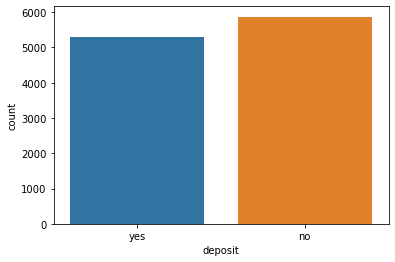

In [609]:
plt.figure()
ax = sns.countplot(x = 'deposit', data = df)
plt.show()

# 2. Exploración visual de datos

In [610]:
categorias=[variable for variable in df.columns if (df[variable].dtypes=='object')]
categorias.pop(-1)

'deposit'

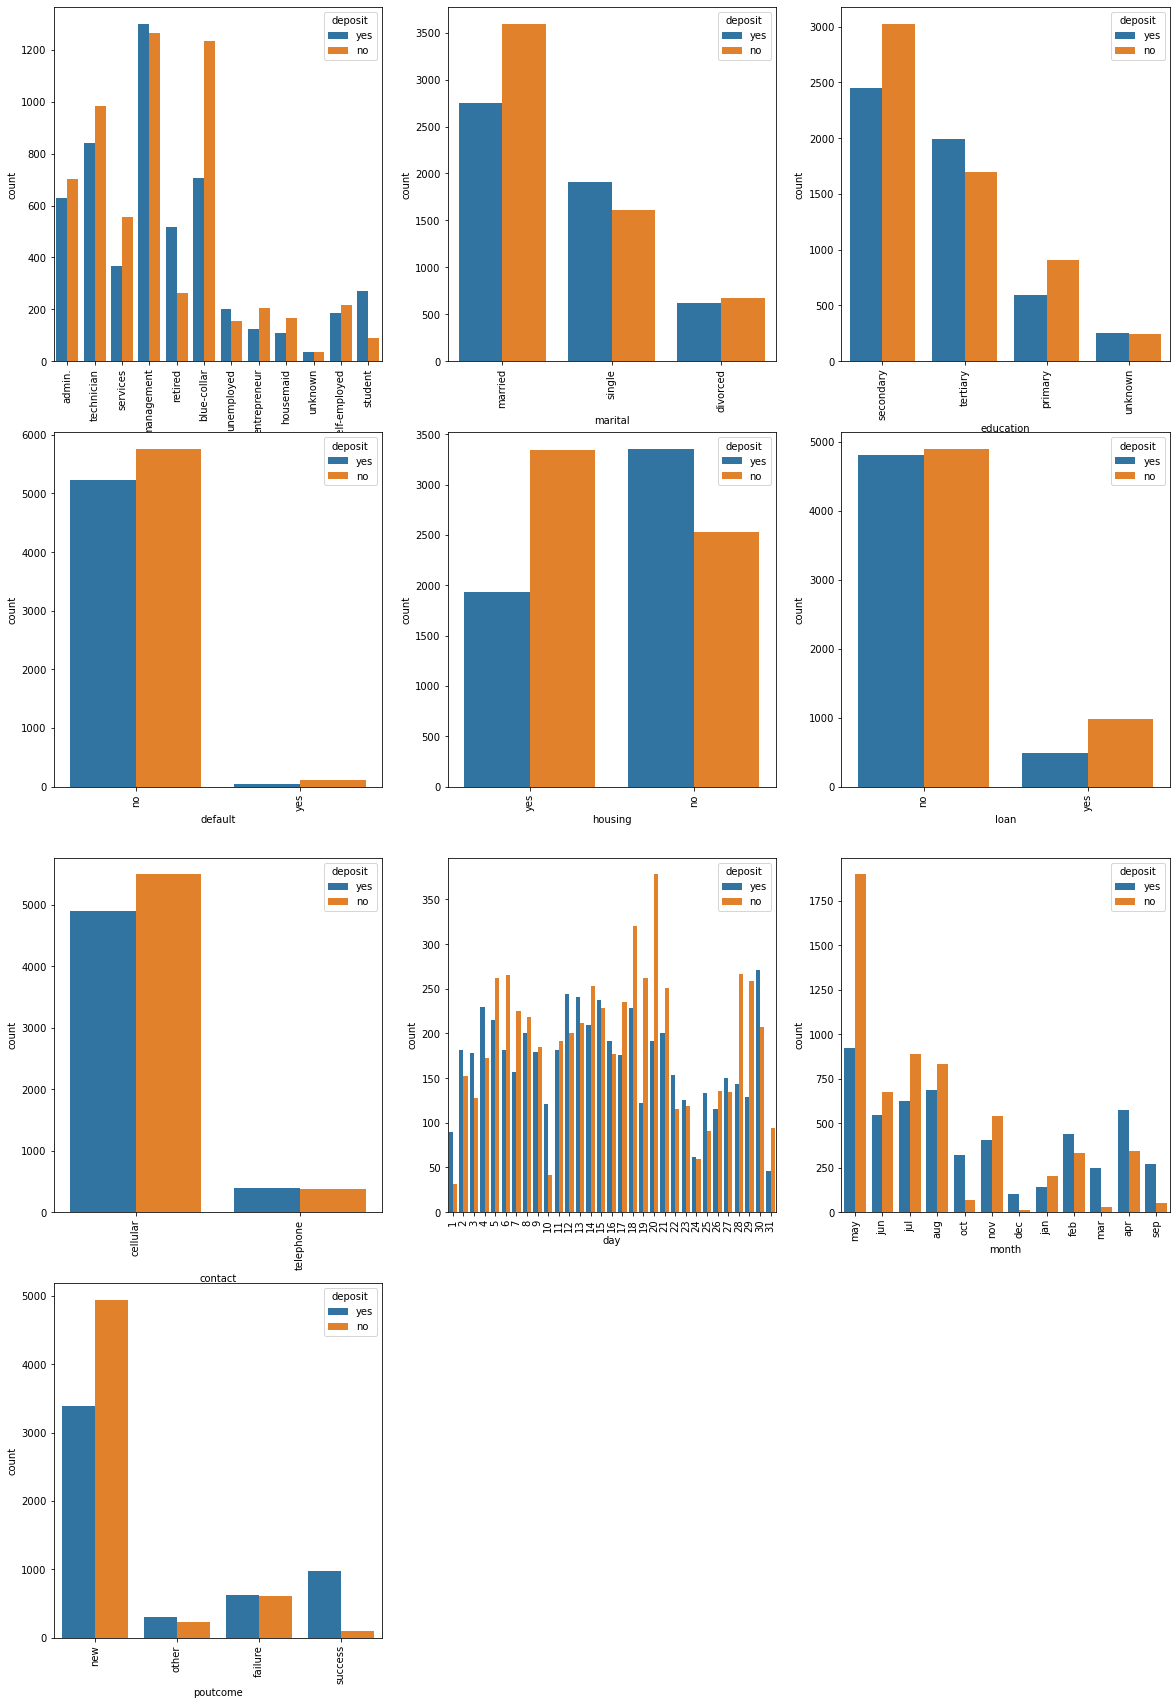

In [611]:
plt.figure(figsize=(20,30))
plotnumber=1
for categoria in categorias:
    ax = plt.subplot(4,3,plotnumber)
    sns.countplot(x=categoria,data=df,hue = 'deposit')
    plt.xlabel(categoria)
    plt.xticks(rotation = 90)
    plotnumber+=1

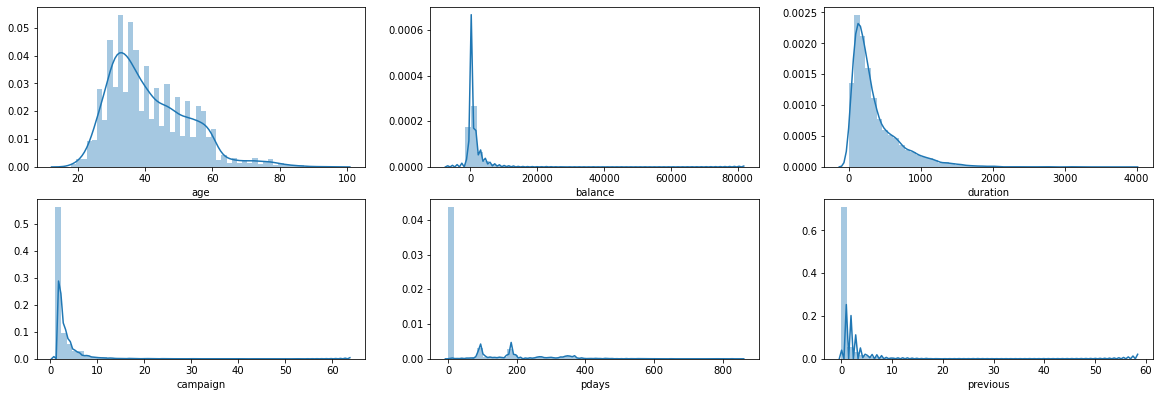

In [612]:
numericas=[variable for variable in df.columns if (df[variable].dtypes=='int64')]
plt.figure(figsize=(20,10))
plotnumber=1
for variable in numericas:
    ax = plt.subplot(3,3,plotnumber)
    sns.distplot(df[variable])
    plt.xlabel(variable)
    plotnumber+=1
plt.show()

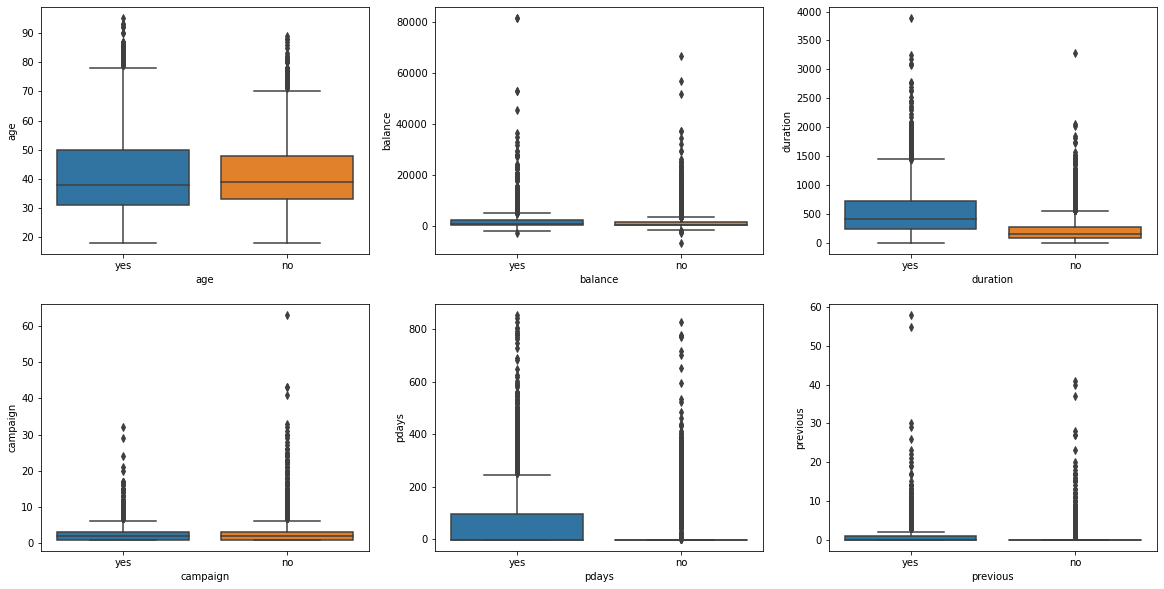

In [613]:
plt.figure(figsize=(20,10))
plotnumber =1
for variable in numericas:
    ax = plt.subplot(2,3,plotnumber)
    sns.boxplot(x="deposit", y= df[variable], data=df)
    plt.xlabel(variable)
    plotnumber+=1
plt.show()

In [614]:
for i in numericas:
    print (i)
    Q99=df[i].quantile(0.99)
    df=df[(df[i]< Q99)]
    print(df.shape)

age
(11030, 17)
balance
(10918, 17)
duration
(10808, 17)
campaign
(10671, 17)
pdays
(10564, 17)
previous
(10449, 17)


In [615]:
df.reset_index(drop=True, inplace=True)

# 3. Procesado y transformación de datos

Creación de variables dummies y normalización

In [496]:
df_num=df.select_dtypes(include='int64')
ss=StandardScaler()
num_scal=ss.fit_transform(df_num)
df_scal = pd.DataFrame(num_scal, columns = df_num.columns)

In [497]:
df_scal.head()

,age,balance,duration,campaign,pdays,previous
0,1.631175,0.526637,2.228759,-0.709310,-0.483851,-0.439523
1,1.362885,-0.624965,3.613717,-0.709310,-0.483851,-0.439523
2,0.021440,-0.011078,3.359536,-0.709310,-0.483851,-0.439523
3,1.273456,0.593288,0.719970,-0.709310,-0.483851,-0.439523
4,1.184026,-0.555307,1.026290,-0.165461,-0.483851,-0.439523


In [498]:
df_scal.shape

(10449, 6)

In [499]:
df_cat=df.select_dtypes(include='object')
df_cat=df_cat.drop('deposit',axis=1)
df_cat=pd.get_dummies(df_cat,columns=df_cat.columns)

In [500]:
df_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_new,poutcome_other,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [501]:
df_cat.shape

(10449, 74)

In [502]:
df['deposit'] = df['deposit'].map({'yes': 1,'no': 0})
df_deposit=df['deposit']
df_deposit=df_deposit.to_frame(name='deposit')
df_deposit.head()

,deposit
0,1
1,1
2,1
3,1
4,1


In [503]:
df_deposit.shape

(10449, 1)

In [504]:
df=pd.concat([df_scal,df_cat,df_deposit],axis=1)
df.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_new,poutcome_other,poutcome_success,deposit
0,1.631175,0.526637,2.228759,-0.709310,-0.483851,-0.439523,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,1.362885,-0.624965,3.613717,-0.709310,-0.483851,-0.439523,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,0.021440,-0.011078,3.359536,-0.709310,-0.483851,-0.439523,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
3,1.273456,0.593288,0.719970,-0.709310,-0.483851,-0.439523,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,1.184026,-0.555307,1.026290,-0.165461,-0.483851,-0.439523,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [505]:
df.shape

(10449, 81)

# 4. Construcción de modelos

Separación en test/train

In [506]:
y = df.deposit
X = df.drop('deposit', axis = 1)

In [507]:
x_train, x_test, y_train, y_test = train_test_split(X, y,random_state=30)

## 4.1. Ranfom Forest

Búsqueda de hiperparámetros

In [508]:
param_rf = {'n_estimators':[5, 10, 100, 150],
            'max_features':[3, 5, 7, 9],
            'max_depth':[None, 5, 10, 20],
            'criterion':['gini', 'entropy']}

model_forest = RandomForestClassifier(random_state=1)
grid_forest = GridSearchCV(estimator = model_forest,
                           param_grid = param_rf,
                           cv = 5,
                           scoring='accuracy')

grid_forest.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'max_features': [3, 5, 7, 9],
                         'n_estimators': [5, 10, 100, 150]},
             scoring='accuracy')

In [509]:
grid_forest.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 7,
 'n_estimators': 100}

In [510]:
grid_forest.best_score_

0.8360109822486749

Construcción del modelo

In [511]:
model_forest = RandomForestClassifier(n_jobs=-1, n_estimators = 100, criterion = 'gini', max_depth = None, max_features = 7, random_state = 1)
model_forest.fit(x_train, y_train)

RandomForestClassifier(max_features=7, n_jobs=-1, random_state=1)

### Resultados Random Forest

In [512]:
y_train_pred_RF = model_forest.predict(x_train)
y_test_pred_RF = model_forest.predict(x_test)

Matriz de confusión

In [513]:
confusion_matrix_train_RF = confusion_matrix(y_train, y_train_pred_RF)
confusion_matrix_test_RF = confusion_matrix(y_test, y_test_pred_RF)

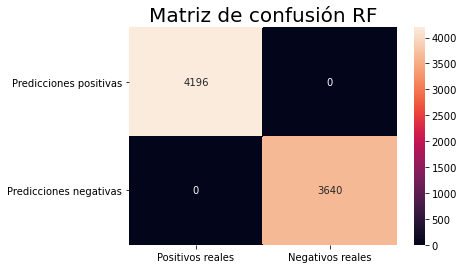

In [514]:
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_train_RF, annot=True, fmt="d")
plt.title("Matriz de confusión RF", fontsize=20)
ax.set_xticklabels(['Positivos reales', 'Negativos reales'], fontsize=10)
ax.set_yticklabels(['Predicciones positivas', 'Predicciones negativas'], fontsize=10, rotation=360)
plt.show()

In [515]:
print('La matriz de confusión para entrenamiento normalizada es')
print(confusion_matrix_train_RF / (sum(confusion_matrix_train_RF)))
print('La matriz de confusión para test normalizada es')
print(confusion_matrix_test_RF / (sum(confusion_matrix_test_RF)))

La matriz de confusión para entrenamiento normalizada es
[[1. 0.]
 [0. 1.]]
La matriz de confusión para test normalizada es
[[0.88288288 0.18188915]
 [0.11711712 0.81811085]]


Métricas train

In [516]:
print('Exactitud RF train:',accuracy_score(y_train, y_train_pred_RF))
print('Precisión RF train:',precision_score(y_train,y_train_pred_RF))
print('Exhaustividad RF train:',recall_score(y_train,y_train_pred_RF))

Exactitud RF train: 1.0
Precisión RF train: 1.0
Exhaustividad RF train: 1.0


Métricas test

In [517]:
precision_RF = accuracy_score(y_test, y_test_pred_RF)
exactitud_RF = precision_score(y_test,y_test_pred_RF)
exhaustividad_RF = recall_score(y_test,y_test_pred_RF)
print('Exactitud RF test:', precision_RF)
print('Precisión RF test:', exactitud_RF)
print('Exhaustividad RF test:', exhaustividad_RF)

Exactitud RF test: 0.8511289705319556
Precisión RF test: 0.8181108508977362
Exhaustividad RF test: 0.8704318936877077


Curva ROC y AUC

In [518]:
fpr_RF,tpr_RF,threshold =roc_curve(y_test,y_test_pred_RF)

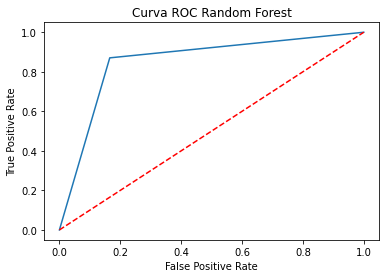

In [519]:
plt.figure()
plt.plot(fpr_RF,tpr_RF)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Random Forest')
plt.show()

In [521]:
auc_RF = roc_auc_score(y_test,y_test_pred_RF)
print('AUC_RF:',auc_RF)

AUC_RF: 0.8525331931178071


## 4.2. SVM Classifier

Búsqueda de hiperparámetros

In [576]:
model_svm = SVC(random_state=1)

param_svm = {'C': [0.001,0.01,0.1, 1, 5, 10, 50,100],  
              'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001], 
              'kernel': ['linear','rbf']}
                                            
grid_svm = GridSearchCV(estimator = model_svm,
                        param_grid = param_svm,
                        scoring='accuracy',
                        cv = 5)
                         
grid_svm.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
                         'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [577]:
grid_svm.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [578]:
grid_svm.best_score_

0.8342250237682821

Construcción del modelo

In [579]:
model_svm = SVC(C = 1, gamma = 0.1, kernel = 'rbf',  random_state = 1)
model_svm.fit(x_train, y_train)

SVC(C=1, gamma=0.1, random_state=1)

### Resultados SVM

In [580]:
y_train_pred_SVM = model_svm.predict(x_train)
y_test_pred_SVM = model_svm.predict(x_test)

Matriz de confusión normalizada

In [581]:
confusion_matrix_train_SVM = confusion_matrix(y_train, y_train_pred_SVM)
confusion_matrix_test_SVM = confusion_matrix(y_test, y_test_pred_SVM)

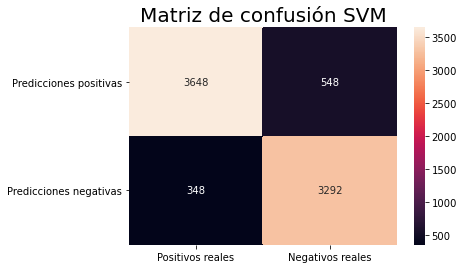

In [582]:
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_train_SVM, annot=True, fmt="d")
plt.title("Matriz de confusión SVM", fontsize=20)
ax.set_xticklabels(['Positivos reales', 'Negativos reales'], fontsize=10)
ax.set_yticklabels(['Predicciones positivas', 'Predicciones negativas'], fontsize=10, rotation=360)
plt.show()

In [583]:
print('La matriz de confusión para entrenamiento normalizada es')
print(confusion_matrix_train_SVM / (sum(confusion_matrix_train_SVM)))
print('La matriz de confusión para test normalizada es')
print(confusion_matrix_test_SVM / (sum(confusion_matrix_test_SVM)))

La matriz de confusión para entrenamiento normalizada es
[[0.91291291 0.14270833]
 [0.08708709 0.85729167]]
La matriz de confusión para test normalizada es
[[0.88435374 0.18527132]
 [0.11564626 0.81472868]]


Métricas train

In [584]:
print('Exactitud SVM train:',accuracy_score(y_train, y_train_pred_SVM))
print('Precisión SVM train:',precision_score(y_train,y_train_pred_SVM))
print('Exhaustividad SVM train:',recall_score(y_train,y_train_pred_SVM))

Exactitud SVM train: 0.8856559469116896
Precisión SVM train: 0.8572916666666667
Exhaustividad SVM train: 0.9043956043956044


Métricas test

In [585]:
precision_SVM = accuracy_score(y_test, y_test_pred_SVM)
exactitud_SVM = precision_score(y_test,y_test_pred_SVM)
exhaustividad_SVM = recall_score(y_test,y_test_pred_SVM)

print('Exactitud SVM test:', precision_SVM)
print('Precisión SVM test:', exactitud_SVM)
print('Exhaustividad SVM test:', exhaustividad_SVM)

Exactitud SVM test: 0.849980864906238
Precisión SVM test: 0.8147286821705426
Exhaustividad SVM test: 0.8729235880398671


Curva ROC y AUC

In [586]:
fpr_SVM,tpr_SVM,threshold =roc_curve(y_test,y_test_pred_SVM)

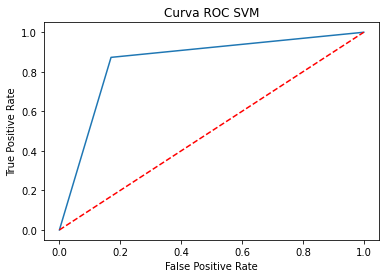

In [587]:
plt.figure()
plt.plot(fpr_SVM,tpr_SVM)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC SVM')
plt.show()

In [588]:
auc_SVM = roc_auc_score(y_test,y_test_pred_SVM)
print('AUC SVM:', auc_SVM)

AUC SVM: 0.85164987067004


## 4.3. KNN Classifier

Búsqueda de hiperparámetros

In [522]:
model_knn = KNeighborsClassifier()
grid_knn=GridSearchCV(estimator = model_knn,
                      param_grid = {'n_neighbors':[3,7,9,10,12,15,18,20,50]},
                      scoring = 'accuracy',
                      cv=10)
grid_knn.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 7, 9, 10, 12, 15, 18, 20, 50]},
             scoring='accuracy')

In [523]:
grid_knn.best_params_

{'n_neighbors': 9}

In [524]:
grid_knn.best_score_

0.8015524408997315

Construcción del modelo

In [527]:
model_knn = KNeighborsClassifier(n_neighbors=9)
model_knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=9)

### Resultados KNN

In [528]:
y_train_pred_KNN = model_knn.predict(x_train)
y_test_pred_KNN = model_knn.predict(x_test)

Matriz de confusión normalizada

In [529]:
confusion_matrix_train_KNN = confusion_matrix(y_train, y_train_pred_KNN)
confusion_matrix_test_KNN = confusion_matrix(y_test, y_test_pred_KNN)

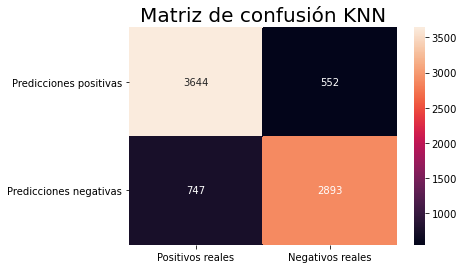

In [530]:
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_train_KNN, annot=True, fmt="d")
plt.title("Matriz de confusión KNN", fontsize=20)
ax.set_xticklabels(['Positivos reales', 'Negativos reales'], fontsize=10)
ax.set_yticklabels(['Predicciones positivas', 'Predicciones negativas'], fontsize=10, rotation=360)
plt.show()

In [531]:
print('La matriz de confusión para entrenamiento normalizada es')
print(confusion_matrix_train_KNN / (sum(confusion_matrix_train_KNN)))
print('La matriz de confusión para test normalizada es')
print(confusion_matrix_test_KNN / (sum(confusion_matrix_test_KNN)))

La matriz de confusión para entrenamiento normalizada es
[[0.8298793  0.16023222]
 [0.1701207  0.83976778]]
La matriz de confusión para test normalizada es
[[0.80849629 0.18584071]
 [0.19150371 0.81415929]]


Métricas train

In [532]:
print('Exactitud KNN train:',accuracy_score(y_train, y_train_pred_KNN))
print('Precisión KNN train:',precision_score(y_train,y_train_pred_KNN))
print('Exhaustividad KNN train:',recall_score(y_train,y_train_pred_KNN))

Exactitud KNN train: 0.8342266462480857
Precisión KNN train: 0.8397677793904209
Exhaustividad KNN train: 0.7947802197802197


Métricas test

In [533]:
precision_KNN = accuracy_score(y_test, y_test_pred_KNN)
exactitud_KNN = precision_score(y_test,y_test_pred_KNN)
exhaustividad_KNN = recall_score(y_test,y_test_pred_KNN)

print('Exactitud KNN test:', precision_KNN)
print('Precisión KNN test:', exactitud_KNN)
print('Exhaustividad KNN test:', exhaustividad_KNN)

Exactitud KNN test: 0.8109452736318408
Precisión KNN test: 0.8141592920353983
Exhaustividad KNN test: 0.7641196013289037


Curva ROC y AUC

In [534]:
fpr_KNN,tpr_KNN,threshold =roc_curve(y_test,y_test_pred_KNN)

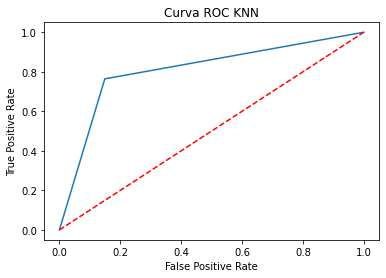

In [535]:
plt.figure()
plt.plot(fpr_KNN,tpr_KNN)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC KNN')
plt.show()

In [536]:
auc_KNN = roc_auc_score(y_test,y_test_pred_KNN)
print('AUC KNN:', auc_SVM)

AUC KNN: 0.8489241562900103


## 4.4. Naïve Bayes

Construcción del modelo

In [537]:
model_gb=GaussianNB()
model_gb.fit(x_train,y_train)

GaussianNB()

### Resultados NB 

In [538]:
y_train_pred_NB = model_gb.predict(x_train)
y_test_pred_NB = model_gb.predict(x_test)

Matriz de confusión normalizada

In [539]:
confusion_matrix_train_NB = confusion_matrix(y_train, y_train_pred_NB)
confusion_matrix_test_NB = confusion_matrix(y_test, y_test_pred_NB)

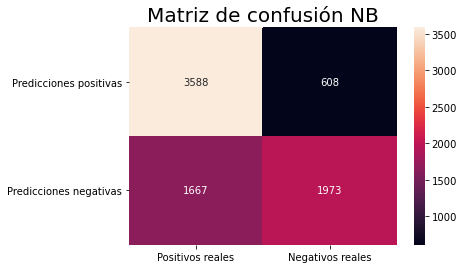

In [540]:
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_train_NB, annot=True, fmt="d")
plt.title("Matriz de confusión NB", fontsize=20)
ax.set_xticklabels(['Positivos reales', 'Negativos reales'], fontsize=10)
ax.set_yticklabels(['Predicciones positivas', 'Predicciones negativas'], fontsize=10, rotation=360)
plt.show()

In [541]:
print('La matriz de confusión para entrenamiento normalizada es')
print(confusion_matrix_train_NB / (sum(confusion_matrix_train_NB)))
print('La matriz de confusión para test normalizada es')
print(confusion_matrix_test_NB / (sum(confusion_matrix_test_NB)))

La matriz de confusión para entrenamiento normalizada es
[[0.68277831 0.23556761]
 [0.31722169 0.76443239]]
La matriz de confusión para test normalizada es
[[0.69477912 0.22758621]
 [0.30522088 0.77241379]]


Métricas train

In [542]:
print('Exactitud NB train:',accuracy_score(y_train, y_train_pred_NB))
print('Precisión NB train:',precision_score(y_train,y_train_pred_NB))
print('Exhaustividad NB train:',recall_score(y_train,y_train_pred_NB))

Exactitud NB train: 0.7096733027054619
Precisión NB train: 0.7644323905462999
Exhaustividad NB train: 0.542032967032967


Métricas test

In [543]:
precision_NB = accuracy_score(y_test, y_test_pred_NB)
exactitud_NB = precision_score(y_test,y_test_pred_NB)
exhaustividad_NB = recall_score(y_test,y_test_pred_NB)

print('Exactitud NB test:', precision_NB)
print('Precisión NB test:', exactitud_NB)
print('Exhaustividad NB test:', exhaustividad_NB)

Exactitud NB test: 0.7206276310753923
Precisión NB test: 0.7724137931034483
Exhaustividad NB test: 0.5581395348837209


Curva ROC y AUC

In [544]:
fpr_NB,tpr_NB,threshold =roc_curve(y_test,y_test_pred_NB)

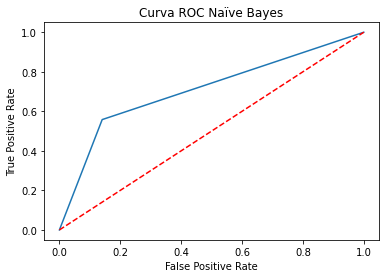

In [545]:
plt.figure()
plt.plot(fpr_NB,tpr_NB)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Naïve Bayes')
plt.show()

In [546]:
auc_NB = roc_auc_score(y_test,y_test_pred_NB)
print('AUC NB:',auc_NB)

AUC NB: 0.7088071698549194


## 4.5. Regresión logística 

Búsqueda de hiperparámetros

In [548]:
model_rl = LogisticRegression(max_iter = 1000)

param_rl = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
            'penalty': ['l1','l2'],
            'solver': ['liblinear','saga']}
                                            
grid_rl = GridSearchCV(estimator = model_rl,
                        param_grid = param_rl,
                        scoring = 'accuracy',
                        cv = 5)

grid_rl.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [549]:
grid_rl.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [550]:
grid_rl.best_score_

0.8172523540367008

Construcción del modelo

In [551]:
model_RL = LogisticRegression(max_iter = 1000, penalty = 'l1', solver = 'liblinear', random_state=1, C = 10)
model_RL.fit(x_train,y_train)

LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=1,
                   solver='liblinear')

### Resultados

In [552]:
y_train_pred_RL = model_RL.predict(x_train)
y_test_pred_RL = model_RL.predict(x_test)

Matriz de confusión normalizada

In [553]:
confusion_matrix_train_RL = confusion_matrix(y_train, y_train_pred_RL)
confusion_matrix_test_RL = confusion_matrix(y_test, y_test_pred_RL)

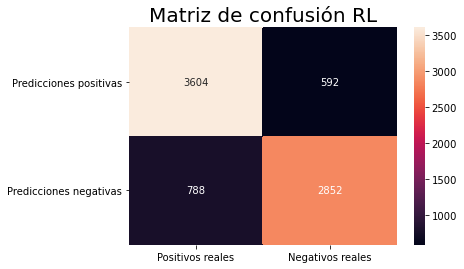

In [554]:
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_train_RL, annot=True, fmt="d")
plt.title("Matriz de confusión RL", fontsize=20)
ax.set_xticklabels(['Positivos reales', 'Negativos reales'], fontsize=10)
ax.set_yticklabels(['Predicciones positivas', 'Predicciones negativas'], fontsize=10, rotation=360)
plt.show()

In [555]:
print('La matriz de confusión para entrenamiento normalizada es')
print(confusion_matrix_train_RL / (sum(confusion_matrix_train_RL)))
print('La matriz de confusión para test normalizada es')
print(confusion_matrix_test_RL / (sum(confusion_matrix_test_RL)))

La matriz de confusión para entrenamiento normalizada es
[[0.82058288 0.17189315]
 [0.17941712 0.82810685]]
La matriz de confusión para test normalizada es
[[0.82933516 0.17244367]
 [0.17066484 0.82755633]]


Métricas train

In [556]:
print('Exactitud RL train:',accuracy_score(y_train, y_train_pred_RL))
print('Precisión RL train:',precision_score(y_train,y_train_pred_RL))
print('Exhaustividad RL train:',recall_score(y_train,y_train_pred_RL))

Exactitud RL train: 0.8238897396630934
Precisión RL train: 0.8281068524970964
Exhaustividad RL train: 0.7835164835164835


Métricas test

In [557]:
precision_RL = accuracy_score(y_test, y_test_pred_RL)
exactitud_RL = precision_score(y_test,y_test_pred_RL)
exhaustividad_RL = recall_score(y_test,y_test_pred_RL)

print('Exactitud RL test:', precision_RL)
print('Precisión RL test:', exactitud_RL)
print('Exhaustividad RL test:', exhaustividad_RL)

Exactitud RL test: 0.8285495598928435
Precisión RL test: 0.8275563258232236
Exhaustividad RL test: 0.7931893687707641


Curva ROC y AUC

In [558]:
fpr_RL,tpr_RL,threshold =roc_curve(y_test,y_test_pred_RL)

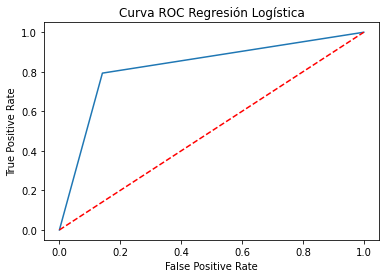

In [559]:
plt.figure()
plt.plot(fpr_RL,tpr_RL)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC Regresión Logística')
plt.show()

In [560]:
auc_RL = roc_auc_score(y_test,y_test_pred_RL)
print('AUC RL:',auc_RL)

AUC RL: 0.8259772251944665


# 5. Resultados

Variables relevantes

In [571]:
relevancia = model_forest.feature_importances_
variables_relevancia = pd.Series(relevancia,index=x_train.columns).sort_values(ascending=False)

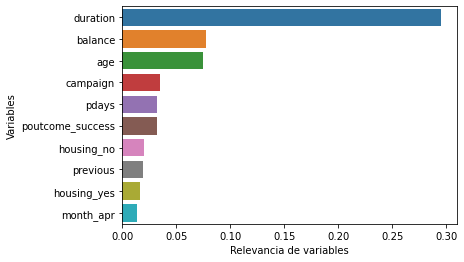

In [572]:
sns.barplot(x=variables_relevancia[0:10], y=variables_relevancia.index[0:10])
plt.xlabel("Relevancia de variables")
plt.ylabel("Variables")
plt.show()

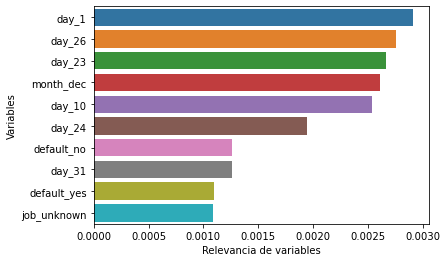

In [573]:
sns.barplot(x=variables_relevancia[-10:], y=variables_relevancia.index[-10:])
plt.xlabel("Relevancia de variables")
plt.ylabel("Variables")
plt.show()

Comparación métricas

In [589]:
df_res = pd.DataFrame()
df_res['Modelos'] = ['RandomForest','SVM','KNeighbors','NaiveBayes', 'RegresionLogistica']
df_res['Exactitud'] = [precision_RF, precision_SVM, precision_KNN, precision_NB, precision_RL]
df_res['Precisión']=[exactitud_RF, exactitud_SVM, exactitud_KNN, exactitud_NB, exactitud_RL]
df_res['Exhaustividad']=[exhaustividad_RF, exhaustividad_SVM, exhaustividad_KNN, exhaustividad_NB, exhaustividad_RL]

In [590]:
cm = sns.light_palette('seagreen',as_cmap=True)
res = df_res.style.background_gradient(cmap=cm)
res

,Modelos,Exactitud,Precisión,Exhaustividad
0,RandomForest,0.851129,0.818111,0.870432
1,SVM,0.849981,0.814729,0.872924
2,KNeighbors,0.810945,0.814159,0.764120
3,NaiveBayes,0.720628,0.772414,0.558140
4,RegresionLogistica,0.828550,0.827556,0.793189


Comparación curvas ROC y AUC

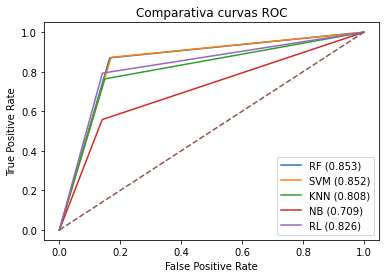

In [591]:
plt.figure()
plt.plot(fpr_RF, tpr_RF, label = 'RF ' "(%0.3f)" % auc_RF)
plt.plot(fpr_SVM, tpr_SVM, label = 'SVM '"(%0.3f)" % auc_SVM)
plt.plot(fpr_KNN, tpr_KNN, label = 'KNN '"(%0.3f)" % auc_KNN)
plt.plot(fpr_NB, tpr_NB, label = 'NB '"(%0.3f)" % auc_NB)
plt.plot(fpr_RL, tpr_RL, label = 'RL '"(%0.3f)" % auc_RL)
plt.plot([0, 1], [0, 1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa curvas ROC')
plt.legend()
plt.show()

In [592]:
df_auc = pd.DataFrame()
df_auc['Modelos'] = ['RandomForest','SVM','KNeighbors','NaiveBayes', 'RegresionLogistica']
df_auc['AUC'] = [auc_RF, auc_SVM, auc_KNN, auc_NB, auc_RL]
orden = df_auc.sort_values('AUC', ascending = False)
orden

,Modelos,AUC
0,RandomForest,0.852533
1,SVM,0.851650
4,RegresionLogistica,0.825977
2,KNeighbors,0.807539
3,NaiveBayes,0.708807
